In [2]:
import sys, os





# Detect if running inside Jupyter
if "__file__" in globals():
    # Running as a .py script
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
else:
    # Running inside Jupyter Notebook
    # Assume notebook is inside project/reproduction/
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

sys.path.append(project_root)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from utils.data_utils_newest import gen_star_from_x1, get_true_frequencies, gen_progressive
from utils.metrics import compute_mse
from utils.spl import random_split_perturb, random_split_estimate
from utils.rs_fd import rs_fd_perturb, rs_fd_estimate
from utils.rs_rfd import rs_rfd_perturb, rs_rfd_estimate
from utils.corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)


mpl.rcParams['pdf.fonttype'] = 42   # TrueType
mpl.rcParams['ps.fonttype'] = 42    # TrueType for EPS


mpl.rc('font', family='DejaVu Serif')


mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['mathtext.fontset'] = 'cm'     # Math font
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30
# ---------------- helpers ----------------
def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}



def _build_p_y_table_minimal(est_I, epsilon, n2, domain, cols):
    return {
        (a, b): float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
        for a in cols for b in cols if a != b
    }


In [26]:
import numpy as np
import pandas as pd

def compute_pairwise_correlations(df):
    """Return list of ((Xi, Xj), corr) sorted by pair."""
    corr = df.astype(float).corr()
    cols = df.columns
    pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            pairs.append(((cols[i], cols[j]), corr.iloc[i, j]))
    return pairs


def correlation_table_syna_synb(
    rhos=(0.1, 0.5, 0.9),
    n=20000,
    domain=[0,1,2,3],
    d=4,
    seed=42,
    x1_marginal=None,
    q_marginal=None,
):
    """
    Computes pairwise Pearson correlations for:
      - SynA (STAR model)
      - SynB (Progressive model)
    across multiple rho values.

    Prints in a clean table form.
    """

    if x1_marginal is None:
        x1_marginal = {v: 1.0/len(domain) for v in domain}

    if seed is not None:
        np.random.seed(seed)

    # To preserve column ordering
    colnames = [f"X{i+1}" for i in range(d)]

    # Storage: { pair: [SynA_rho1, SynB_rho1, SynA_rho2, SynB_rho2, ...]}
    results = {}

    for rho in rhos:

        # ======== Generate SynA (Star model) ========
        df_star = gen_star_from_x1(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=rho,
            q_marginal=q_marginal,
            seed=seed,
        )
        df_star.columns = colnames
        star_pairs = compute_pairwise_correlations(df_star)

        # ======== Generate SynB (Progressive model) ========
        df_prog = gen_progressive(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=rho,
            q_marginal=q_marginal,
            seed=seed,
        )
        df_prog.columns = colnames
        prog_pairs = compute_pairwise_correlations(df_prog)

        # Store results
        for ((x_i, x_j), corr_a), (_, corr_b) in zip(star_pairs, prog_pairs):
            key = (x_i, x_j)
            if key not in results:
                results[key] = []
            results[key].extend([corr_a, corr_b])

    # =========================
    # Print formatted table
    # =========================
    header = ["Pair"]
    for rho in rhos:
        header += [f"SynA(rho={rho})", f"SynB(rho={rho})"]

    # Determine widths
    col_widths = [max(len(h), 12) for h in header]

    # Print header
    line = "".join(h.ljust(col_widths[i]) for i, h in enumerate(header))
    print("\n" + line)
    print("-" * len(line))

    # Print rows
    averages = np.zeros(len(rhos) * 2)

    for pair, vals in results.items():
        row = [f"({pair[0]}, {pair[1]})"] + [f"{v:.3f}" for v in vals]
        for i, cell in enumerate(row):
            print(cell.ljust(col_widths[i]), end="")
        print()

        averages += np.array(vals)

    # Average row
    avg_vals = averages / len(results)
    avg_row = ["Average"] + [f"{v:.3f}" for v in avg_vals]
    for i, cell in enumerate(avg_row):
        print(cell.ljust(col_widths[i]), end="")

    print("\n")


In [28]:
if __name__ == "__main__":
    correlation_table_syna_synb(
        rhos=[0.1, 0.5, 0.9],
        n=20000,
        domain=[0,1,2,3],
        d=4,
        seed=42
    )



Pair        SynA(rho=0.1)SynB(rho=0.1)SynA(rho=0.5)SynB(rho=0.5)SynA(rho=0.9)SynB(rho=0.9)
------------------------------------------------------------------------------------------
(X1, X2)    0.100        0.100        0.491        0.491        0.899        0.899        
(X1, X3)    0.094        0.012        0.495        0.241        0.900        0.897        
(X1, X4)    0.100        0.011        0.508        0.128        0.903        0.812        
(X2, X3)    0.007        0.098        0.231        0.490        0.808        0.804        
(X2, X4)    0.009        0.006        0.247        0.243        0.810        0.730        
(X3, X4)    0.007        0.099        0.251        0.495        0.811        0.904        
Average     0.053        0.054        0.370        0.348        0.855        0.841        



'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


Plot saved to: C:\Users\ss6365\Desktop\Corr-RR\fig\py_all.pdf


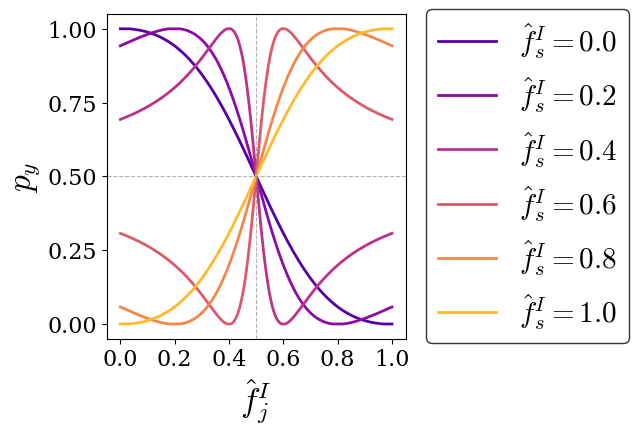

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# Function to compute optimal p_y
# ==========================================================
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d * (d - 1) / 2
    S2 = (d - 1) * d * (2 * d - 1) / 6

    μa = sum(v * f_a[v] for v in domain)
    μb = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2 * μb - S1
    b1 = 2 * νb2 - S2
    Y0 = (Δ / 2) * a0 + (S1 / 2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2 * f_a[v] - 1) + (2 * f_b[v] - 1)) for v in domain)
    α2 = sum((2 * f_a[v] - 1)**2 + (2 * f_b[v] - 1)**2 for v in domain)

    num = (b1 - 2 * Y0 * a1) / (2 * n * Δ) + α1 / (8 * d)
    den = a1**2 / (2 * n) - α2 / (4 * d)

    p_star = num / den if den != 0 else q
    return float(np.clip(p_star, 0.0, 1.0))


# ==========================================================
# MAIN: Run the p_y plot experiment
# ==========================================================
if __name__ == "__main__":

    # --- constants ---
    domain = [0, 1]       # Binary domain
    epsilon = 0.1
    n = 1000

    # --- f_a curves to plot ---
    fa_fixed_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    colors = plt.cm.plasma(np.linspace(0.15, 0.85, len(fa_fixed_values)))
    fb_values = np.linspace(0, 1, 400)

    # --- figure ---
    plt.figure(figsize=(7, 5))

    for fa_val, color in zip(fa_fixed_values, colors):
        py_values = []
        for fb_val in fb_values:
            f_a = {0: fa_val, 1: 1 - fa_val}
            f_b = {0: fb_val, 1: 1 - fb_val}
            py_values.append(optimal_p_y(f_a, f_b, epsilon, n, domain))

        label = rf'$\hat{{f}}^I_s = {fa_val}$'
        plt.plot(fb_values, py_values, color=color, linewidth=2, label=label)

    # --- quadrant lines ---
    plt.axvline(0.5, color="gray", linestyle="--", linewidth=0.8, alpha=0.6)
    plt.axhline(0.5, color="gray", linestyle="--", linewidth=0.8, alpha=0.6)

    # --- axis ---
    plt.xlabel(r'$\hat{f}^I_j$', fontsize=24)
    plt.ylabel(r'$p_y$', fontsize=24)

    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(-0.05, 1.05)

    # --- legend ---
    plt.legend(fontsize=21, loc='center left',
               bbox_to_anchor=(1.02, 0.5),
               frameon=True, edgecolor='black')

    plt.tight_layout()

    # --- save ---
    out_path = r"C:\Users\ss6365\Desktop\Corr-RR\fig\py_all.pdf"
    plt.savefig(out_path, bbox_inches='tight')

    print(f"Plot saved to: {out_path}")


In [38]:
import os
import pandas as pd
import numpy as np
from itertools import combinations


# -------------------------------------------------------------
# Detect project root (same logic you use everywhere)
# -------------------------------------------------------------
if "__file__" in globals():
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
else:
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))


# -------------------------------------------------------------
# Compute dataset statistics
# -------------------------------------------------------------
def dataset_stats(df):
    cols = df.columns.tolist()
    d = len(cols)

    # domain size = maximum number of categories among attributes
    domain_size = max(len(df[c].unique()) for c in cols)

    num_users = len(df)

    # Pearson correlation (absolute)
    corr_mat = df.corr(numeric_only=True)
    corr_vals = []
    for c1, c2 in combinations(df.columns, 2):
        corr_vals.append(abs(corr_mat.loc[c1, c2]))

    if corr_vals:
        corr_min = round(min(corr_vals), 3)
        corr_max = round(max(corr_vals), 3)
        corr_range = (corr_min, corr_max)
    else:
        corr_range = ("N/A", "N/A")

    return d, domain_size, num_users, corr_range


# -------------------------------------------------------------
# MAIN — prints statistics for all .csv in a given folder
# -------------------------------------------------------------
if __name__ == "__main__":

    # YOU ONLY NEED TO CHANGE THIS
    dataset_folder = "preprocessed_real_data"

    folder_path = os.path.join(project_root, dataset_folder)

    print("\n=== REAL-WORLD DATASET STATISTICS ===\n")
    #print("Project root:", project_root)
    #print("Dataset folder:", folder_path)
    print()

    # Load all CSV files in folder
    for filename in os.listdir(folder_path):

        if not filename.endswith(".csv"):
            continue

        dataset_name = filename.replace(".csv", "")
        full_path = os.path.join(folder_path, filename)

        print(f"Dataset: {dataset_name}")
        #print(f"  Path: {full_path}")

        df = pd.read_csv(full_path)

        # Encode categorical columns
        df_enc = df.copy()
        for col in df_enc.columns:
            df_enc[col] = df_enc[col].astype("category").cat.codes

        d, dom, users, corr = dataset_stats(df_enc)

        print(f"  d (num attributes):      {d}")
        print(f"  |D| (max domain size):   {dom}")
        print(f"  # Users:                 {users}")
        print(f"  Correlation range:       {corr[0]} to {corr[1]}")
        print("----------------------------------------")




=== REAL-WORLD DATASET STATISTICS ===


Dataset: adult
  d (num attributes):      3
  |D| (max domain size):   2
  # Users:                 48842
  Correlation range:       0.421 to 0.96
----------------------------------------
Dataset: adult_10k
  d (num attributes):      3
  |D| (max domain size):   2
  # Users:                 10000
  Correlation range:       0.432 to 0.957
----------------------------------------
Dataset: clave
  d (num attributes):      2
  |D| (max domain size):   2
  # Users:                 10800
  Correlation range:       0.299 to 0.299
----------------------------------------
Dataset: mushroom
  d (num attributes):      2
  |D| (max domain size):   5
  # Users:                 8124
  Correlation range:       0.21 to 0.21
----------------------------------------


In [31]:
pwd

'C:\\Users\\ss6365\\Desktop\\Corr-RR\\Corr-RR\\experiments_notebook'

In [37]:
import pandas as pd
import os

# === USER INPUT ===
input_path = r'C:\Users\ss6365\Desktop\Corr-RR\Corr-RR\preprocessed_real_data\adult.csv'
output_dir = r'C:\Users\ss6365\Desktop\Corr-RR\Corr-RR\preprocessed_real_data'
output_file = "adult_10k.csv"
N = 10000

# === PROCESS ===
df = pd.read_csv(input_path)

n_rows = min(N, len(df))

df_sampled = df.sample(n=n_rows, random_state=42)

os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, output_file)
df_sampled.to_csv(output_path, index=False)

print(f"Saved {n_rows} rows to: {output_path}")


Saved 10000 rows to: C:\Users\ss6365\Desktop\Corr-RR\Corr-RR\preprocessed_real_data\adult_10k.csv


In [43]:
import os
import pandas as pd
import numpy as np
from itertools import combinations


# -------------------------------------------------------------
# Detect project root (same logic you use everywhere)
# -------------------------------------------------------------
if "__file__" in globals():
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
else:
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))


# -------------------------------------------------------------
# Compute dataset statistics
# -------------------------------------------------------------
def dataset_stats(df):
    cols = df.columns.tolist()
    d = len(cols)

    # domain size = maximum number of categories among attributes
    domain_size = max(len(df[c].unique()) for c in cols)

    num_users = len(df)

    # Pearson correlation (absolute)
    corr_mat = df.corr(numeric_only=True)
    corr_vals = []
    for c1, c2 in combinations(df.columns, 2):
        corr_vals.append(abs(corr_mat.loc[c1, c2]))

    if corr_vals:
        corr_min = round(min(corr_vals), 3)
        corr_max = round(max(corr_vals), 3)
        corr_range = (corr_min, corr_max)
    else:
        corr_range = ("N/A", "N/A")

    return d, domain_size, num_users, corr_range


# -------------------------------------------------------------
# MAIN — prints statistics for all .csv in a given folder
# -------------------------------------------------------------
if __name__ == "__main__":

    # YOU ONLY NEED TO CHANGE THIS
    dataset_folder = "preprocessed_real_data"

    folder_path = os.path.join(project_root, dataset_folder)

    print("\n=== REAL-WORLD DATASET STATISTICS ===\n")
    #print("Project root:", project_root)
    #print("Dataset folder:", folder_path)
    print()

    # Load all CSV files in folder
    for filename in os.listdir(folder_path):

        if not filename.endswith(".csv"):
            continue

        dataset_name = filename.replace(".csv", "")
        full_path = os.path.join(folder_path, filename)

        print(f"Dataset: {dataset_name}")
        #print(f"  Path: {full_path}")

        df = pd.read_csv(full_path)

        # Encode categorical columns
        df_enc = df.copy()
        for col in df_enc.columns:
            df_enc[col] = df_enc[col].astype("category").cat.codes

        d, dom, users, corr = dataset_stats(df_enc)

        print(f"  d (num attributes):      {d}")
        print(f"  |D| (max domain size):   {dom}")
        print(f"  # Users:                 {users}")
        print(f"  Correlation range:       {corr[0]} to {corr[1]}")
        print("----------------------------------------")




=== REAL-WORLD DATASET STATISTICS ===




FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\ss6365\\Desktop\\Corr-RR\\Corr-RR\\preprocessed_real_data'